# Multiple linear regression model
### Let's mimic the process of building our trading model of SPY, base on the historical data of different stock markets

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# import all stock market data into DataFrame
aord = pd.read_csv('../data/indice/ALLOrdinary.csv')
nikkei = pd.read_csv('../data/indice/Nikkei225.csv')
hsi = pd.read_csv('../data/indice/HSI.csv')
daxi = pd.read_csv('../data/indice/DAXI.csv')
cac40 = pd.read_csv('../data/indice/CAC40.csv')
sp500 = pd.read_csv('../data/indice/SP500.csv')
dji = pd.read_csv('../data/indice/DJI.csv')
nasdaq =pd.read_csv('../data/indice/nasdaq_composite.csv')
spy = pd.read_csv('../data/indice/SPY.csv')

In [8]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,2653.909912,2661.500000,2597.810059,2609.629883,2609.629883,2076690000
1,2008-01-03,2611.959961,2624.270020,2592.179932,2602.679932,2602.679932,1970200000
2,2008-01-04,2571.080078,2571.080078,2502.679932,2504.649902,2504.649902,2516310000
3,2008-01-07,2514.149902,2521.620117,2471.229980,2499.459961,2499.459961,2600100000
4,2008-01-08,2506.969971,2527.419922,2440.510010,2440.510010,2440.510010,2566480000


## Step 1: Data Munging

In [9]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [10]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
0,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,15.500000,-71.679688,-464.320313,146.529999
1,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-50.100097,-162.750000,-48.830078,144.910004
2,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,99.370117,143.339996
3,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-117.399903,216.951171,234.450195,141.809998
4,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-27.500000,-354.060547,-158.209961,142.080002


In [11]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy          1
spy_lag1     1
sp500        1
nasdaq       1
dji          1
cac40        3
daxi        11
aord         2
hsi         57
nikkei      57
Price        0
dtype: int64

In [12]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [13]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [14]:
# save this indicepanel for part 4.5
path_save = '../data/indice/indicepanel.csv'
indicepanel.to_csv(path_save)

In [15]:
print(indicepanel.shape)

(2678, 11)


## Step 2: Data Spliting

In [16]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


## Step 3: Explore the train data set

In [17]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

ModuleNotFoundError: No module named 'pandas.tools'

## Step 4: Check the correlation of each index between spy

In [18]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40       0.076886
daxi        0.019410
aord        0.048200
hsi        -0.038361
nikkei      0.035379
Name: spy, dtype: float64


In [19]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.133
Date:                Wed, 26 Jul 2023   Prob (F-statistic):             0.0245
Time:                        18:01:59   Log-Likelihood:                -1643.1
No. Observations:                1000   AIC:                             3306.
Df Residuals:                     990   BIC:                             3355.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0798      0.040      1.993      0.047       0.001       0.158
spy_lag1      -0.1233      0.092     -1.340      0.180      -0.304       0.057
sp500          0.0178      0.014      1.273      0.203      -0.010       0.045
nasdaq         0.0047      0.004      1.240      0.215      -0.003       0.012
dji           -0.0023      0.001     -1.588      0.113      -0.005       0.001
cac40          0.0021      0.001      2.485      0.013       0.000       0.004
aord           0.0017      0.001      1.497      0.135      -0.001       0.004
daxi           0.0003      0.000      0.724      0.469      -0.001       0.001
nikkei         0.0004      0.000      1.293      0.196      -0.000       0.001
hsi           -0.0003      0.000     -1.412      0.158      -0.001       0.000
==============================================================================
Omnibus:                       85.811   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.379
Skew:                          -0.444   Prob(JB):                     7.73e-52
Kurtosis:                       5.205   Cond. No.                         385.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Make prediction

In [20]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

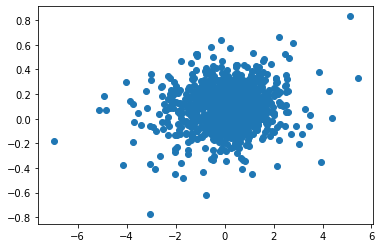

In [21]:
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [22]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [23]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [24]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.010102,0.013609
RMSE,1.257534,1.759693
